# Filtro de partículas


Cada partícula vai ser representada por uma lista [x,y,theta]

Trabalhe com 2 listas:

	S = []  # Vai conter as n partículas

	W = [] # Pesos das partículas

	n_part = # Número de partículas


# Atividades


1. Crie uma função que gere n partículas aleatórias distribuidas uniformemente dentro de uma área minx, miny, maxx, maxy (passados como parâmetros)

	Devolve uma lista com n partículas

2. Descubra como desenhar as n partículas (analise o módulo inspercles)

3. Faça o desenho das partículas

4. Crie uma lista para simular os movimentos do robô

5. Crie uma função que aplica um deslocamento [delta_x, delta_y, delta_theta] com um desvio padrão [std_x, std_y, std_theta] a todas as partículas

6. Desenhe as partículas após o deslocamento

7. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles

Programe a aplicação da equação que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \prod_{j}^M{e^{\frac{-(z_j - \hat{z_j})}{2\sigma^2}}}$$

Ou seja, para cada raio estimado $\hat{z_j}$ e leitura real $z_j$ calcule a probabilidade daquele raio ter acontecido dado que a posição do robô fosse de fato a da partícula


8. Usando os resultados de 7 calcule $P(H|D)$ e insira numa lista de probabilidades das partículas

9. Reamostre as partículas de forma proporcional à probabilidade



In [25]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff


import sys
import os
os.getcwd() 
import sys
sys.path.append(os.getcwd())


import inspercles
reload(inspercles)


%matplotlib inline


In [26]:
!pwd




/home/borg/catkin_ws/src/robot17/particle_filter/jupyter_particle


In [27]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.65
free_thresh =  0.196

inspercles.free_thresh = free_thresh
inspercles.occupied_thresh = occupied_thresh
inspercles.origin = origin
inspercles.resolution = resolution


In [28]:


from PIL import Image as PilImage
pil_image = PilImage.open("scaled_map.pgm", 'r')
np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 480, 480

inspercles.width = 480
inspercles.height = 480




initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
inspercles.initial_pose = initial_pose
pose = [330, 220, math.radians(90)] # posicao "verdadeira" do robo 
inspercles.pose = pose
robot_radius=10   # Raio do robo
inspercles.robot_radius = robot_radius


# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []



    
    
    
    

## Mapa com posicao inicial

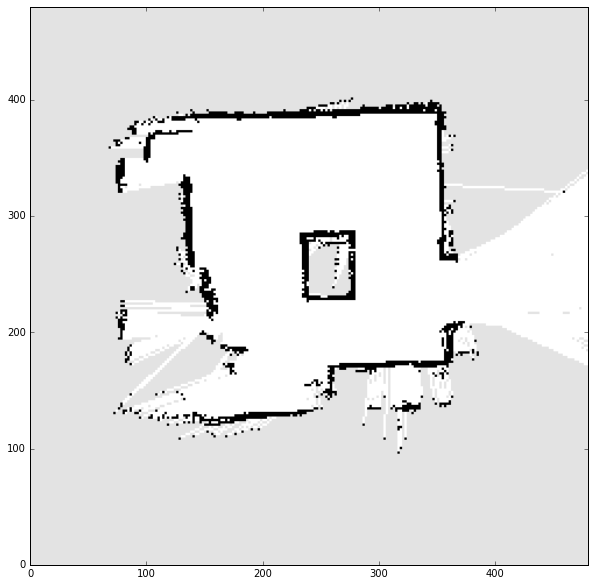

In [29]:
inspercles.nb_draw_map(np_image)

In [30]:
# Inicializa as particulas
inspercles.nb_initialize_particle_cloud()

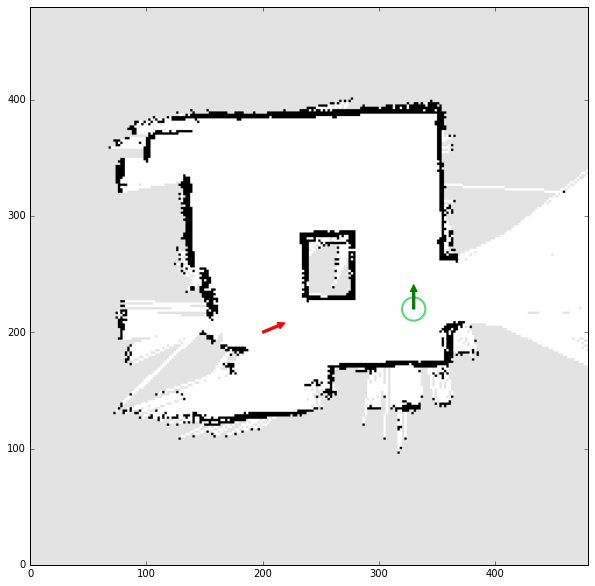

In [31]:
inspercles.nb_draw_map(np_image, particles = particle_cloud, initial_position = initial_pose, pose=pose, robot=True)

In [32]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulacao da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posicao do robo, os angulos do sensor e a np_image com o mapa

In [33]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


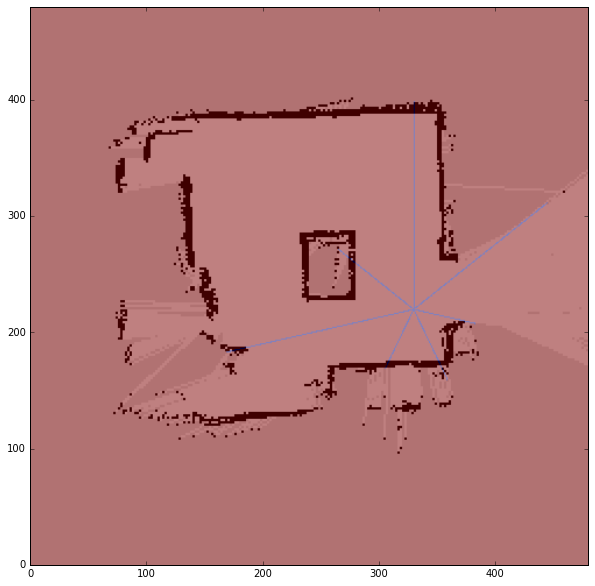

In [34]:
ax = inspercles.nb_draw_map(np_image)
ax.imshow(lidar_map, alpha=0.5)
#nb_draw_map(occupancy_image)

As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [35]:
# As predicoes teoricas das leituras
leituras

{1.5707963267948966: 190.5465822312224,
 2.4683942278205517: 77.98717843338096,
 3.3659921288462069: 151.58495967608397,
 4.2635900298718621: 168.88457596832222,
 5.1611879308975173: 181.5543995611233,
 6.0587858319231724: 123.68508398347798,
 6.9563837329488276: 92.9623579735368,
 7.8539816339744828: 190.5465822312224}

# Laser simulado sobre occupancy field

In [36]:
pose[1]=200
pose[2] = math.radians(180)

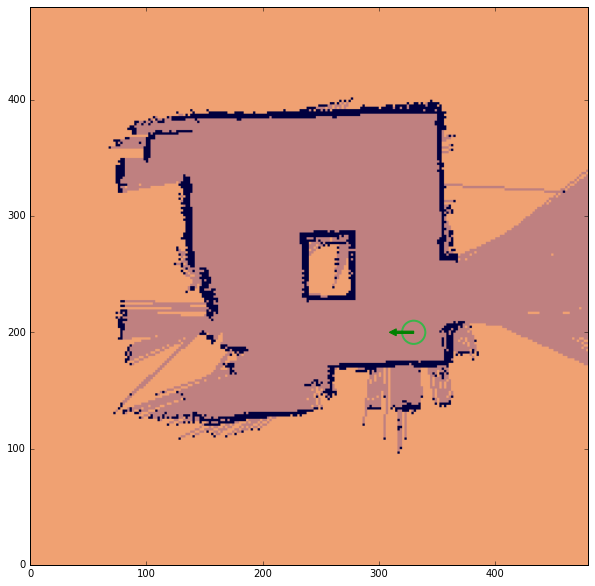

In [37]:
ax = inspercles.nb_draw_map(np_image, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(np_image, alpha=0.5)

In [38]:
leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)


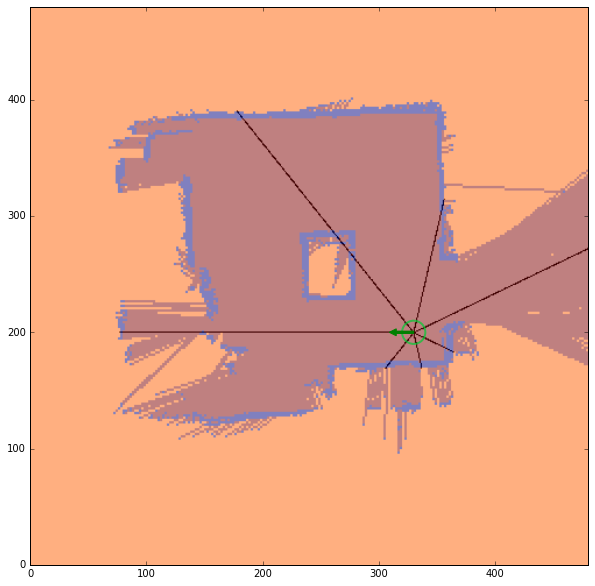

In [39]:
ax = inspercles.nb_draw_map(lidar_map, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(np_image, alpha=0.5)

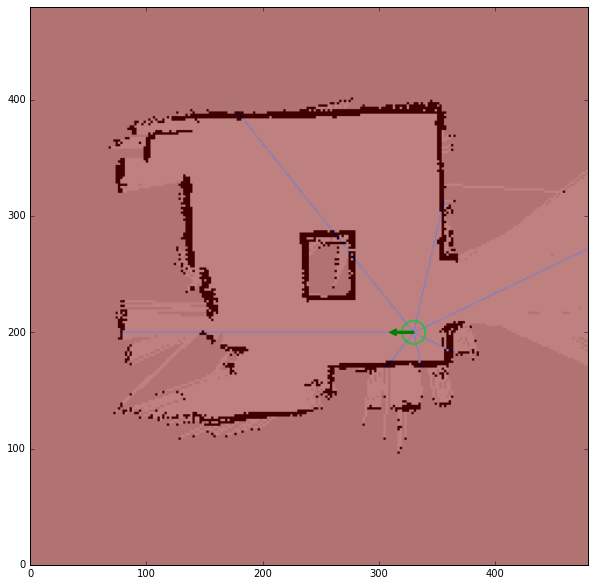

In [40]:
ax = inspercles.nb_draw_map(np_image, pose=pose, robot=True, particles=particle_cloud)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Teste de animacao

In [41]:
# Coloque nesta lista os deslocamentos do robo

movimentos = [[-10, -10, 0], [-10, 10, 0], [-10,0,0], [-10, 0, 0],
              [0,0,math.pi/12.0], [0, 0, math.pi/12.0], [0, 0, math.pi/12],[0,0,-math.pi/4],
              [-5, 0, 0],[-5,0,0], [-5,0,0], [-10,0,0],[-10,0,0], [-10,0,0],[-10,0,0],[-10,0,0],[-15,0,0],
              [0,0,-math.pi/4],[0, 10, 0], [0,10,0], [0, 10, 0], [0,10,0], [0,0,math.pi/8], [0,10,0], [0,10,0], 
              [0,10,0], [0,10,0], [0,10,0],[0,10,0],
              [0,0,-math.radians(90)],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],[math.cos(math.pi/3)*10, math.sin(math.pi/3),0],
              [math.cos(math.pi/3)*10, math.sin(math.pi/3),0]
              
              ]


In [42]:

plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio

frames = 1

for delta in movimentos:
    for i in range(len(pose)):
        pose[i]+=delta[i]
        for elemento in particle_cloud:
            
            std_x = np.random.gaussian(0,2)
            std_y = np.random.gaussian(0,2)
            std_theta = np.random.gaussian(0,5)
            
            desloc_x = delta[0] 
            desloc_y = delta[1]
            desloc_theta = delta[2] 
        
            elemento.x += desloc_x + std_x
            elemento.y += desloc_y + std_y
            elemento.theta += desloc_theta + std_theta
            
        leituras, lidar_map = inspercles.nb_simulate_lidar(pose, angles, np_image)
        
        ax = inspercles.nb_draw_map(np_image, pose=pose, robot=True, particles=particle_cloud)
        #ax.imshow(occupancy_image, alpha=0.2)
        ax.imshow(lidar_map, alpha=0.5)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



Para gerar os gifs e' preciso ter o pacote *imagemagick*

O imagemagick pode ser obtido com o seguinte comando:
    sudo apt-get install imagemagick 
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.fig*, que leremos abaixo:
    

In [43]:
!convert -delay 10 -loop 1 anim*png animated.gif

Infelizmente o IPython Notebook 2 nao parece exibir animacoes em Gif por default, mas voce pode abrir o arquivo no diretorio de trabalho e devera'  ve-lo.

<img src="files/animated.gif">

![](anim.gif)

## Sugestao de atividade:

Coloque os seguintes passos num loop:

- Mova o robo alterando a variavel *pose*

- Atualize as particulas com odometria

- Calcule a verossimilanca das particulas

- Reamostre as particulas

Use as funcoes de plot abundantemente ao longo do desenvolvimento